Ce notebook présente l'ensemble du pipeline : 
- Le scrapping des annonces immobilières en ligne pour la location
- Le nettoyage et la structuration des données
- L'analyse statistique
- La visualisation cartographique
- Le modèle de prédiction de prix basé sur les caractéristique du bien

In [ ]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage plus joli
pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")

# Pour importer config.settings depuis notebooks/
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from config.settings import DATA_PROCESSED_PATH

DATA_PROCESSED_PATH


'data/processed/'

In [2]:
data_file = os.path.join(DATA_PROCESSED_PATH, "immobilier_clean.csv")
data_file


'data/processed/immobilier_clean.csv'

In [3]:
df = pd.read_csv(data_file)
df.head()

,id,title,city,postal_code,region,latitude,longitude,price,charges,surface,price_per_m2,rooms,bedrooms,property_type,ad_type,floor,has_elevator,is_furnished,parking,publication_date,scraped_date,url,source
0,bienici-ics-jol_JOLIS_M2_loc-GES00120002-876,NaN,Sassenage,38360,Auvergne-Rhône-Alpes,45.207122,5.638675,1098.94,NaN,64.38,17.07,3.0,2.0,flat,rent,2.0,True,False,0,2025-11-24,2025-12-06 17:08:05,https://www.bienici.com/annonce/ics-jol_JOLIS_...,bienici
1,bienici-ics-jol_JOLIS_M2_loc-GES01150012-876,NaN,Eybens,38320,Auvergne-Rhône-Alpes,45.131831,5.775986,1073.00,NaN,67.08,16.00,3.0,2.0,flat,rent,0.0,True,False,0,2025-11-01,2025-12-06 17:08:05,https://www.bienici.com/annonce/ics-jol_JOLIS_...,bienici
2,bienici-ics-jol_JOLIS_M2_loc-GES00380002-876,NaN,Sassenage,38360,Auvergne-Rhône-Alpes,45.207122,5.638675,604.86,NaN,25.67,23.56,1.0,0.0,flat,rent,0.0,False,True,0,NaN,2025-12-06 17:08:05,https://www.bienici.com/annonce/ics-jol_JOLIS_...,bienici
3,bienici-ics-jol_JOLIS_M2_loc-GES00380003-876,NaN,Sassenage,38360,Auvergne-Rhône-Alpes,45.207122,5.638675,751.60,NaN,31.43,23.91,2.0,1.0,flat,rent,0.0,False,True,0,NaN,2025-12-06 17:08:05,https://www.bienici.com/annonce/ics-jol_JOLIS_...,bienici
4,bienici-ics-jol_JOLIS_M2_loc-GES00270010-876,NaN,Voiron,38500,Auvergne-Rhône-Alpes,45.368205,5.580688,993.75,NaN,66.00,15.06,3.0,2.0,flat,rent,4.0,True,False,0,NaN,2025-12-06 17:08:05,https://www.bienici.com/annonce/ics-jol_JOLIS_...,bienici


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                235 non-null    object 
 1   title             61 non-null     object 
 2   city              235 non-null    object 
 3   postal_code       235 non-null    int64  
 4   region            235 non-null    object 
 5   latitude          234 non-null    float64
 6   longitude         234 non-null    float64
 7   price             235 non-null    float64
 8   charges           180 non-null    float64
 9   surface           235 non-null    float64
 10  price_per_m2      235 non-null    float64
 11  rooms             235 non-null    float64
 12  bedrooms          235 non-null    float64
 13  property_type     235 non-null    object 
 14  ad_type           235 non-null    object 
 15  floor             169 non-null    float64
 16  has_elevator      235 non-null    bool   
 1

In [5]:
df[["price", "surface", "price_per_m2"]].describe()

,price,surface,price_per_m2
count,235.000000,235.000000,235.000000
mean,974.100340,82.670511,13.627574
std,562.030842,45.647327,7.505454
min,332.000000,10.050000,3.600000
25%,627.575000,51.715000,9.175000
50%,850.000000,71.950000,11.760000
75%,1164.675000,104.335000,14.830000
max,5500.000000,287.330000,45.430000


In [6]:
df["region"].value_counts().head(10)

region
Auvergne-Rhône-Alpes          86
Other                         62
Nouvelle-Aquitaine            30
Pays de la Loire              22
Île-de-France                 17
Occitanie                     17
Provence-Alpes-Côte d'Azur     1
Name: count, dtype: int64

In [7]:
df["city"].value_counts().head(10)

city
Saint-Étienne            24
Roanne                   18
Le Mans                   6
Sassenage                 5
Laval                     5
Le Coteau                 5
Grenoble                  5
Périgueux                 5
Saint-Priest-en-Jarez     4
Châlons-en-Champagne      3
Name: count, dtype: int64

In [8]:
df["property_type"].value_counts()

property_type
flat     172
house     63
Name: count, dtype: int64

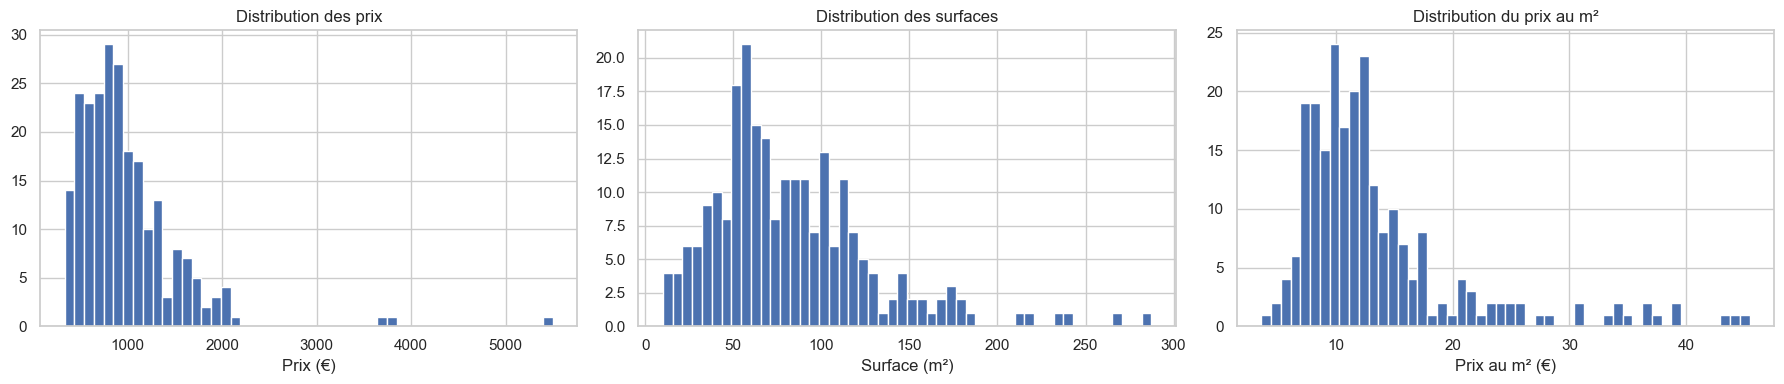

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(df["price"], bins=50)
axes[0].set_title("Distribution des prix")
axes[0].set_xlabel("Prix (€)")

axes[1].hist(df["surface"], bins=50)
axes[1].set_title("Distribution des surfaces")
axes[1].set_xlabel("Surface (m²)")

axes[2].hist(df["price_per_m2"], bins=50)
axes[2].set_title("Distribution du prix au m²")
axes[2].set_xlabel("Prix au m² (€)")

plt.tight_layout()
plt.show()

In [10]:
region_stats = (
    df.dropna(subset=["region", "price_per_m2"])
    .groupby("region")["price_per_m2"]
    .mean()
    .sort_values(ascending=False)
)

region_stats.head(10)

region
Île-de-France                 27.262353
Provence-Alpes-Côte d'Azur    16.950000
Nouvelle-Aquitaine            14.890333
Other                         12.628871
Occitanie                     12.557059
Auvergne-Rhône-Alpes          11.912442
Pays de la Loire              11.565000
Name: price_per_m2, dtype: float64

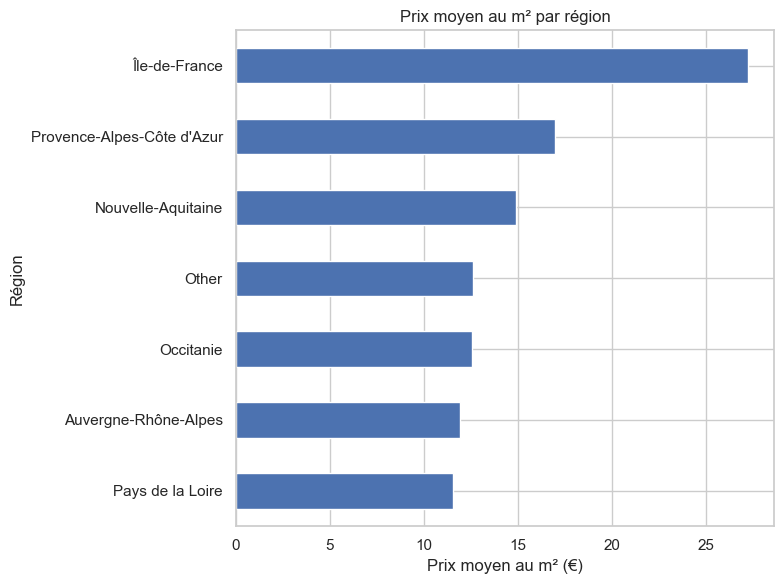

In [11]:
plt.figure(figsize=(8, 6))
region_stats.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Prix moyen au m² par région")
plt.xlabel("Prix moyen au m² (€)")
plt.ylabel("Région")
plt.tight_layout()
plt.show()

In [12]:
city_stats = (
    df.dropna(subset=["city", "price_per_m2"])
    .groupby("city")["price_per_m2"]
    .mean()
    .sort_values(ascending=False)
)

top_n = 20
city_stats.head(top_n)

city
Paris 6e                   45.430
Guyancourt                 39.510
Paris 14e                  37.250
La Garenne-Colombes        36.920
Paris 15e                  36.420
Périgueux                  35.088
Colombes                   33.970
Courbevoie                 33.900
Mandelieu-la-Napoule       32.940
Roquebrune-Cap-Martin      30.560
Versailles                 27.865
Montmorency                26.180
Nice                       25.775
Saint-Denis                25.510
Antibes                    25.230
Crozet                     24.180
Châtillon                  22.360
Rouen                      21.990
Le Chesnay                 21.600
Charbonnières-les-Bains    20.870
Name: price_per_m2, dtype: float64

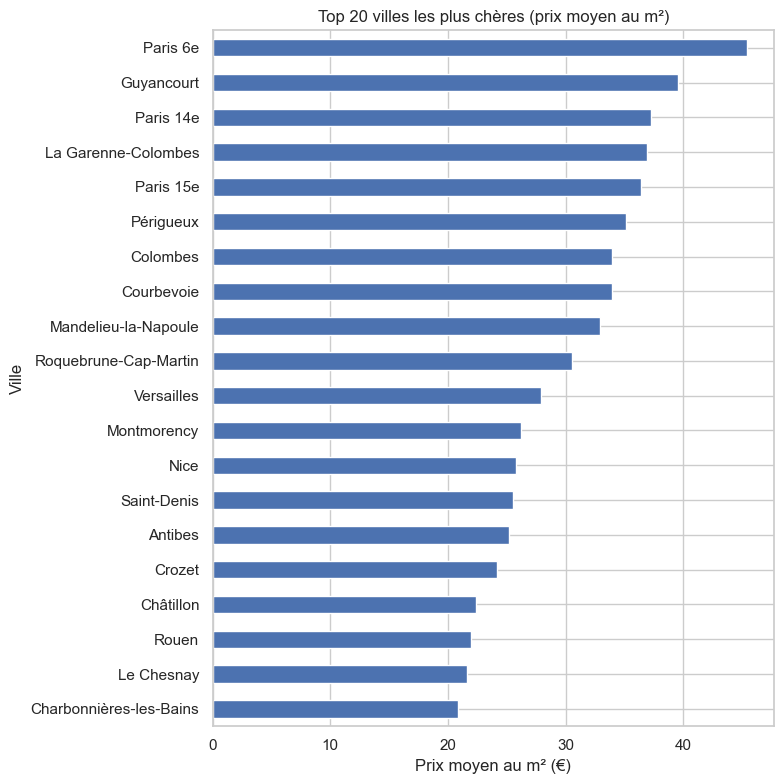

In [13]:
plt.figure(figsize=(8, 8))
city_stats.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} villes les plus chères (prix moyen au m²)")
plt.xlabel("Prix moyen au m² (€)")
plt.ylabel("Ville")
plt.tight_layout()
plt.show()

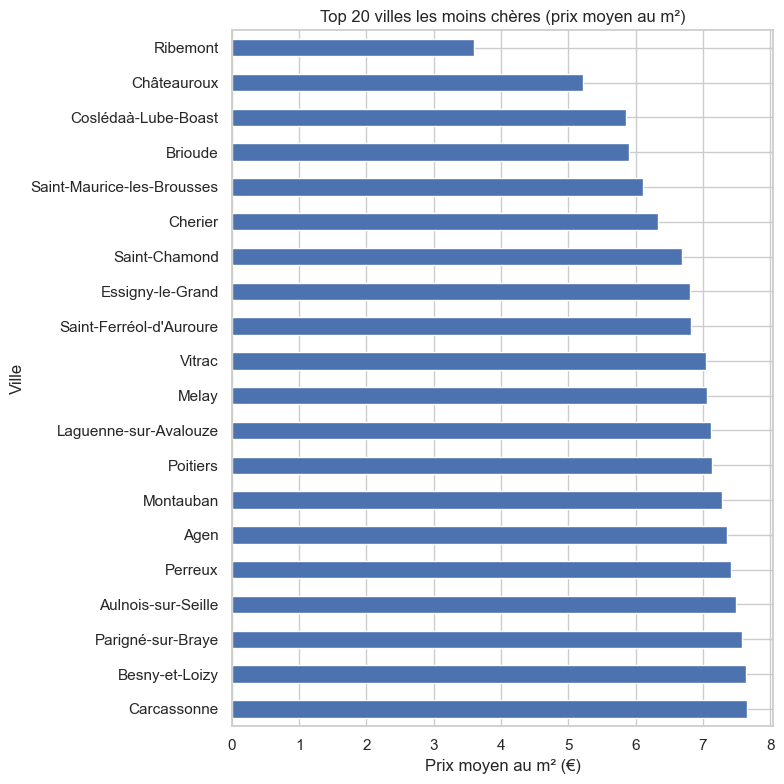

In [14]:
plt.figure(figsize=(8, 8))
city_stats.tail(top_n).plot(kind="barh")
plt.title(f"Top {top_n} villes les moins chères (prix moyen au m²)")
plt.xlabel("Prix moyen au m² (€)")
plt.ylabel("Ville")
plt.tight_layout()
plt.show()

In [15]:
scatter_df = df[["surface", "price_per_m2", "city", "region", "property_type"]].dropna()

len(scatter_df)

235

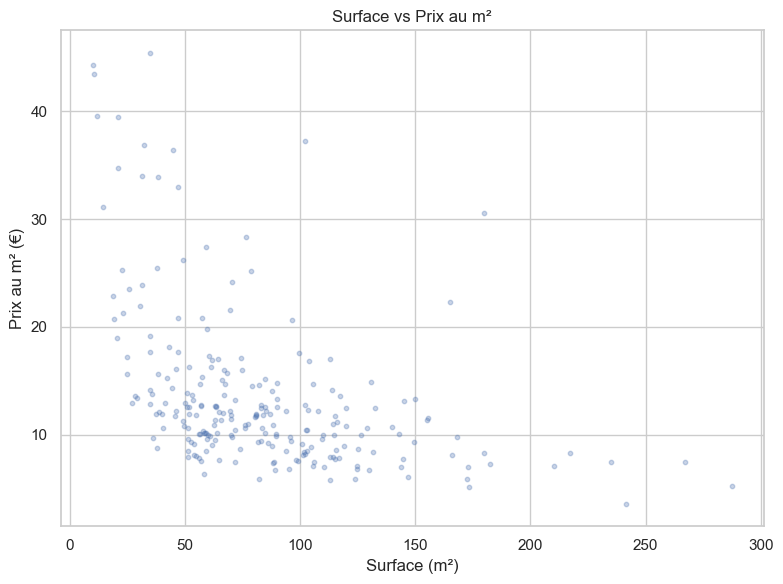

In [16]:
# Echantillonner si > 10 000 lignes
max_points = 10000
if len(scatter_df) > max_points:
    scatter_df_sample = scatter_df.sample(max_points, random_state=42)
else:
    scatter_df_sample = scatter_df.copy()

plt.figure(figsize=(8, 6))
plt.scatter(
    scatter_df_sample["surface"],
    scatter_df_sample["price_per_m2"],
    alpha=0.3,
    s=10
)
plt.title("Surface vs Prix au m²")
plt.xlabel("Surface (m²)")
plt.ylabel("Prix au m² (€)")
plt.tight_layout()
plt.show()


In [17]:
scatter_df[["surface", "price_per_m2"]].corr()

,surface,price_per_m2
surface,1.000000,-0.447042
price_per_m2,-0.447042,1.000000


In [19]:
if "property_type" in df.columns:
    type_stats = (
        df.dropna(subset=["property_type", "price_per_m2"])
        .groupby("property_type")["price_per_m2"]
        .agg(["mean", "median", "count"])
        .sort_values("mean", ascending=False)
    )
    type_stats
else:
    print("Colonne property_type absente.")


In [20]:
if "property_type" in df.columns:
    type_stats = (
        df.dropna(subset=["property_type", "price_per_m2"])
        .groupby("property_type")["price_per_m2"]
        .agg(["mean", "median", "count"])
        .sort_values("mean", ascending=False)
    )
    type_stats
else:
    print("Colonne property_type absente.")


In [21]:
analysis_file = os.path.join(DATA_PROCESSED_PATH, "analysis_results.json")
analysis_file


'data/processed/analysis_results.json'

In [22]:
with open(analysis_file, "r", encoding="utf-8") as f:
    results = json.load(f)

list(results.keys())


['price_distribution',
 'price_per_m2',
 'surface_distribution',
 'correlations',
 'city_analysis',
 'region_analysis',
 'property_type_comparison',
 'price_segmentation',
 'rooms_segmentation',
 'amenities_impact',
 'best_value_properties',
 'outliers',
 'clusters',
 'paris_vs_rest',
 'metadata']

In [23]:
results["price_segmentation"]

{'Economic': {'avg_price': 487.38,
  'avg_price_m2': 13.62,
  'avg_surface': 44.45,
  'avg_rooms': 2.02,
  'count': 55,
  'market_share': 23.404255319148938},
 'Medium': {'avg_price': 876.01,
  'avg_price_m2': 12.5,
  'avg_surface': 81.41,
  'avg_rooms': 3.56,
  'count': 127,
  'market_share': 54.04255319148936},
 'Premium': {'avg_price': 1557.29,
  'avg_price_m2': 15.51,
  'avg_surface': 123.93,
  'avg_rooms': 4.58,
  'count': 50,
  'market_share': 21.27659574468085},
 'Luxury': {'avg_price': 4330.0,
  'avg_price_m2': 30.06,
  'avg_surface': 149.0,
  'avg_rooms': 4.67,
  'count': 3,
  'market_share': 1.276595744680851}}

In [24]:
results["clusters"].keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])